In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !pip install opencv-python==3.4.2.17
# !pip install opencv-contrib-python==3.4.2.17
# !pip install ipython-autotime
# %load_ext autotime

In [ ]:
path_data = "/content/drive/MyDrive/data_droplet"
class_ = os.listdir(path_data)


In [ ]:
def draw_kp(img,kp):
  anh = img.copy()
  anh=cv2.drawKeypoints(anh,kp,anh,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
  plt.imshow(cv2.cvtColor(anh,cv2.COLOR_BGR2RGB))



In [ ]:
sift = cv2.xfeatures2d.SIFT_create()
label = []
data = [] #data bao gom 4304 anh, 2232 anh none va 2072 anh co hat 
all_sift = []
all_img_dir = []
for label_name in class_:
  sub_path = path_data+'/'+label_name
  for filename in os.listdir(sub_path):
    path_image = sub_path+'/'+filename
    img = cv2.imread(path_image)
    if img is not None:
      label.append(label_name)
      all_img_dir.append(path_image)
      img = cv2.GaussianBlur(img,(1,1),0)
      kp,des = sift.detectAndCompute(img, None)
      for d in des:
        all_sift.append(d)
    

In [ ]:
all_sift = np.array(all_sift)

In [ ]:
all_sift.shape

(74993, 128)

In [ ]:
len(label)

4304

In [ ]:
from sklearn.cluster import KMeans
#theo khao sat, anh khong co giot se co mean des = 18, anh co hat la 30
number_of_cluster = 25
kmean = KMeans(n_clusters=number_of_cluster, random_state=15).fit(all_sift)

In [ ]:
all_img_dir = np.array(all_img_dir)
label = np.array(label)
data_size = all_img_dir.shape[0]
test_size  = int(data_size*0.2)
train_size = data_size - test_size
entropy = np.random.permutation(data_size)

In [ ]:
test_size

860

In [ ]:
train_img_bow = []
for image in all_img_dir[entropy[0:train_size]]:
    img = cv2.imread(image)
    if img is not None:
      img = cv2.GaussianBlur(img,(3,3),0)
      kp, des = sift.detectAndCompute(img, None) # kp: keypoint, des: descriptors
      histo = np.zeros(number_of_cluster) #
      nkp = np.size(kp)  #nkp: number of keypoints
      v=[]
      des = np.array(des)
      for d in des:
          idx = kmean.predict(d.reshape(1,-1))
          v.append(idx)
          histo[idx] += 1
          
      histo=np.array(histo) # chuyen ve dang vector numpy
      histo=histo/nkp # normalized

      train_img_bow.append(histo)

In [ ]:
len(train_img_bow)

3444

In [ ]:
test_img_bow = []
for image in all_img_dir[entropy[train_size:-1]]:
    img = cv2.imread(image)
    if img is not None:
      img = cv2.GaussianBlur(img,(3,3),0)
      kp, des = sift.detectAndCompute(img, None) # kp: keypoint, des: descriptors
      histo = np.zeros(number_of_cluster) #
      nkp = np.size(kp)  #nkp: number of keypoints
      v=[]
      des = np.array(des)
      for d in des:
          idx = kmean.predict(d.reshape(1,-1))
          v.append(idx)
          histo[idx] += 1
          
      histo=np.array(histo) # chuyen ve dang vector numpy
      histo=histo/nkp # normalized
    
      test_img_bow.append(histo)


In [ ]:
len(label[entropy[0:train_size]])

3444

In [ ]:
len(all_img_dir)

4304

In [ ]:
len(label)

4304

***Train Model***

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

classifier = SVC(C=15.0,kernel='rbf',gamma='scale')
classifier.fit(train_img_bow,label[entropy[0:train_size]])
y_pred = classifier.predict(test_img_bow)
print("Accuracy is : %.2f"%(accuracy_score(label[entropy[train_size:-1]],y_pred)*100)+" %")

Accuracy is : 86.96 %


In [ ]:
train_size 

3444

In [ ]:
# from sklearn.neural_network import MLPClassifier
# mlp = MLPClassifier(hidden_layer_sizes=100,activation='relu',verbose=True, max_iter=600000,tol=0.0001)
# mlp.fit(train_img_bow,label[entropy[0:train_size]])
# res=mlp.predict(test_img_bow)
# print(accuracy_score(label[entropy[train_size:-1]],res))

**Kiểm thử **

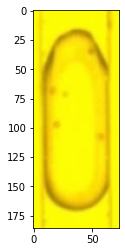

In [ ]:
im2 = cv2.imread("/content/drive/MyDrive/data_droplet/Particle/particle (15).jpg")
im3 = cv2.GaussianBlur(im2,(3,3),0)
kp1,d1 = sift.detectAndCompute(im2, None)
kp2,d2 = sift.detectAndCompute(im3, None)
plt.imshow(cv2.cvtColor(im3,cv2.COLOR_BGR2RGB))

In [ ]:
im3 = cv2.GaussianBlur(im2,(3,3),0)
kp1,d1 = sift.detectAndCompute(im3, None) # tinh sift cua anh

histo = np.zeros(number_of_cluster) # tinh % feature cua anh
nkp = np.size(kp1)  #nkp: number of keypoints
v=[]
des = np.array(d1)
for d in d1:
    idx = kmean.predict(d.reshape(1,-1))
    v.append(idx)
    histo[idx] += 1
histo=np.array(histo) # chuyen ve dang vector numpy
histo=histo/nkp # normalized

classifier.predict(histo.reshape(1,-1))

array(['Particle'], dtype='<U8')

In [ ]:
d1.shape

22


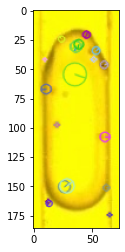

In [ ]:
draw_kp(im2,kp1)
print(len(kp2))

**Lưu lại bộ trọng số của bộ train KNN và SVM**

---





In [ ]:
# import pickle
# test_img_bow = np.array(test_img_bow).reshape(-1,25)
# file_sift = '/content/drive/MyDrive/Colab Notebooks/sift_svm_clf_droplet.pkl'
# # file_knn = '/content/knn_clf_feature.pkl'  
# # with open(file_sift,'wb') as f:
# #   pickle.dump(classifier,f)
# # with open(file_knn,'wb') as f:
# #   pickle.dump(kmean,f)
# loaded_model = pickle.load(open(file_sift, 'rb'))
# result = loaded_model.score(test_img_bow, label[entropy[train_size:-3]])

Hàm phát hiện bằng xử lý ảnh

In [ ]:
def conan_old(tan):
    gray = cv2.cvtColor(tan, cv2.COLOR_BGR2GRAY) # chuyen sang thang mau xam
    gray = cv2.GaussianBlur(gray,(1,1),0) # lam mo hinh anh de loc nhieu
    canny_cv = cv2.Canny(gray,600,1200,apertureSize=5,L2gradient= True) # lay vien
    cn = cv2.dilate(canny_cv, None, iterations=3) # tang do day vien
    cn = cv2.erode(cn, None, iterations=3) # bao mong do day vien
    plt.imshow(canny_cv,cmap="gray")
    cnts, hierarchy = cv2.findContours(cn, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) # lay countour
    cnts = [x for x in cnts if cv2.contourArea(x) > 5 and cv2.contourArea(x)<100 and cv2.arcLength(x,False) > 40 ] # dieu kien de loai bo vien and cv2.arcLength(x,True) >5 and cv2.arcLength(x,True) <400
    return len(cnts)
def feed(img):
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i][j] >= 177 and img[i][j] <= 179:
                img[i][j]+= 20
            elif img[i][j] <=175 and img[i][j]  >= 160:
                img[i][j] -= 30
    return img


def conan_new(tan):
    consider = tan.copy()[:,:,1]
    tet = feed(consider)
    gray = cv2.cvtColor(tan, cv2.COLOR_BGR2GRAY) # chuyen sang thang mau xam
    gray = cv2.GaussianBlur(gray,(1,1),0) # lam mo hinh anh de loc nhieu
    canny_cv = cv2.Canny(gray,550,1200,apertureSize=5,L2gradient= True) # lay vien
    plt.imshow(canny_cv,cmap="gray")
    cnts, hierarchy = cv2.findContours(canny_cv, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) # lay countour
    cnts = [x for x in cnts if cv2.contourArea(x) > 5 and cv2.arcLength(x,False) <80 ]  
    return len(cnts)


In [ ]:
y_pred_xla = []
count_pred_0 = 0
for i in all_img_dir[entropy[train_size:-1]]:
  img = cv2.imread(i)
  if conan_new(img) == 0:
    y_pred_xla.append("None")
    count_pred_0+=1
  else:
    y_pred_xla.append("Particle")
y_pred_xla = np.array(y_pred_xla)
print(count_pred_0)


In [ ]:
y_pred.shape


In [ ]:
print("Accuracy is : %.2f"%(accuracy_score(label[entropy[train_size:-1]],y_pred_xla)*100)+" %")

In [ ]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(label[entropy[train_size:-1]], y_pred_xla)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["None", "Particle"])
cm_display.plot()

In [ ]:
count_true_none =0
for i in label[entropy[train_size:-1]]:
  if i =="None":
    count_true_none+=1
count_true_none

In [ ]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(label[entropy[train_size:-1]], y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["None", "Particle"])
cm_display.plot()